In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_499800/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io

import os
import time

## 超参数设置

In [3]:
domain = (-1, 1, -1, 1)
xmin, xmax, ymin, ymax = domain
mlp_layers = [2] + [40]*8 + [2]
mlp_layers_k = [2] + [20]*3 + [1]
n_iters = 200000
learning_rate = 1e-3
gamma = 0.6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

## 数据集生成

In [4]:
data = io.loadmat('example1_slt_512.mat')
dx_comp = data['dx_comp']
dx_pml = data['dx_pml']
dy_comp = data['dy_comp']
dy_pml = data['dy_pml']
height = data['height']
width = data['width']
k0 = data['k0']
m = data['m']
n = data['n']
uf = data['uf'].T
x = data['x']
y = data['y']

x.shape

In [5]:
class DatasetHelmholtz:
    def __init__(self, domain):
        self.domain = domain
    
    def train_data(self, N=5000, verbose=None):
        xmin, xmax, ymin, ymax = self.domain
        xx, yy = np.meshgrid(x[0, 256:-256], y[0, 256:-256])
        X_res = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
        f_res_u, f_res_v = self.func_res(X_res)
        uv_data = uf[256:-256, 256:-256].reshape(-1, 1)
        u_data = uv_data.real
        v_data = uv_data.imag
        
        idx = np.random.randint(0,1025*1025,N)
        return X_res[idx], f_res_u[idx], f_res_v[idx], u_data[idx], v_data[idx]
    
    def func_res(self, X_res):
        a = np.pi / (2 * k0.item())
        f_res_u = np.empty(X_res.shape[0])
        
        for i in range(X_res.shape[0]):
            x1, x2 = X_res[i]
            d = ((x1 - 0.5)**2 + (x2 - 0)**2) ** 0.5
            
            if d < 0.5:
                f_res_u[i] = 1 / (np.sqrt(np.pi) * a) * np.exp(- (d/a) ** 2)
            else:
                f_res_u[i] = 0
        f_res_u = f_res_u.reshape(-1, 1)
        
        f_res_v = np.zeros_like(f_res_u)
        return f_res_u, f_res_v
    

dataset = DatasetHelmholtz(domain)
X_res, f_res_u, f_res_v, u_data, v_data = dataset.train_data()
print(X_res.shape, f_res_u.shape, f_res_v.shape, u_data.shape, v_data.shape)

(5000, 2) (5000, 1) (5000, 1) (5000, 1) (5000, 1)


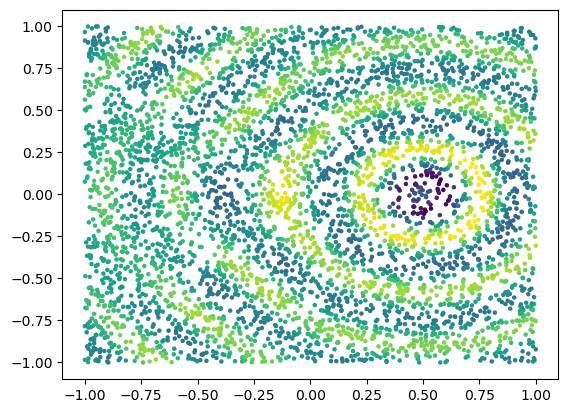

In [6]:
plt.scatter(X_res[:, 0], X_res[:, 1], c=u_data, s=5)

## PINN主干网络

In [7]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            self.model.add_module(f'fc{i+1}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            self.model.add_module(f'act{i+1}', nn.Tanh())
        self.model.add_module(f'fc{len(mlp_layers)-1})', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
    
    def forward(self, X):
        return self.model(X)
    
    
mlp = MLP(mlp_layers)
mlp_k = MLP(mlp_layers_k)
mlp.model

Sequential(
  (fc1): Linear(in_features=2, out_features=40, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=40, out_features=40, bias=True)
  (act3): Tanh()
  (fc4): Linear(in_features=40, out_features=40, bias=True)
  (act4): Tanh()
  (fc5): Linear(in_features=40, out_features=40, bias=True)
  (act5): Tanh()
  (fc6): Linear(in_features=40, out_features=40, bias=True)
  (act6): Tanh()
  (fc7): Linear(in_features=40, out_features=40, bias=True)
  (act7): Tanh()
  (fc8): Linear(in_features=40, out_features=40, bias=True)
  (act8): Tanh()
  (fc9)): Linear(in_features=40, out_features=2, bias=False)
)

## PINN模型

In [8]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [9]:
class PINNHelmholtz(nn.Module):
    def __init__(self, backbone, nn_k):
        super(PINNHelmholtz, self).__init__()
        self.backbone = backbone
        self.nn_k = nn_k
        
        self.a = (20 - 20/1.5)/2
        self.b = (20 - 20/1.5)/2 + 20/1.5
    
    def forward(self, X_res, f_res_u, f_res_v, u_data, v_data):
        f_res_u_pred, f_res_v_pred = self.net_f(X_res)
        uv_pred = self.net_u(X_res)
        u_pred = uv_pred[:, [0]]
        v_pred = uv_pred[:, [1]]

        loss_res_u = torch.mean((f_res_u_pred - f_res_u) ** 2)
        loss_res_v = torch.mean((f_res_v_pred - f_res_v) ** 2)
        loss_data_u = torch.mean((u_pred - u_data) ** 2)
        loss_data_v = torch.mean((v_pred - v_data) ** 2)
        return loss_res_u, loss_res_v, loss_data_u, loss_data_v
    
    def net_u(self, X):
        return self.backbone(X) * 5e-3
    
    def net_k(self, X):
        return self.a * torch.tanh( self.nn_k(X) ) + self.b
    
    def net_f(self, X):
        X.requires_grad_(True)
        uv = self.net_u(X)
        u = uv[:, [0]]
        v = uv[:, [1]]
        
        # 求实部u的梯度
        grad_u = grad(u, X)[0]
        u_x = grad_u[:, [0]]
        u_y = grad_u[:, [1]]
        u_xx = grad(u_x, X)[0][:, [0]]
        u_yy = grad(u_y, X)[0][:, [1]]
        
        # 求虚部v的梯度
        grad_v = grad(v, X)[0]
        v_x = grad_v[:, [0]]
        v_y = grad_v[:, [1]]
        v_xx = grad(v_x, X)[0][:, [0]]
        v_yy = grad(v_y, X)[0][:, [1]]
        
        k = self.net_k(X)
        
        f_res_u_pred = -(u_xx + u_yy) - k**2 * u
        f_res_v_pred = -(v_xx + v_yy) - k**2 * v
        
        return f_res_u_pred, f_res_v_pred
    

pinn = PINNHelmholtz(mlp,mlp_k)

## Adam训练

In [10]:
# 训练
dataset = DatasetHelmholtz(domain)
X_res, f_res_u, f_res_v, u_data, v_data = dataset.train_data()
X_res = torch.from_numpy(X_res).float().to(device)
f_res_u = torch.from_numpy(f_res_u).float().to(device)
f_res_v = torch.from_numpy(f_res_v).float().to(device)
u_data = torch.from_numpy(u_data).float().to(device)
v_data = torch.from_numpy(v_data).float().to(device)

backbone = MLP(mlp_layers)
nn_k = MLP(mlp_layers_k)
pinn = PINNHelmholtz(backbone, nn_k)
pinn = pinn.to(device)

optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=learning_rate)
optimizer_adam_k = optim.Adam(pinn.nn_k.parameters(), lr=learning_rate)
# optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, 
# threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False
lr_sche = ReduceLROnPlateau(optimizer_adam, mode='min', factor=gamma, verbose=True)
lr_sche_k = ReduceLROnPlateau(optimizer_adam_k, mode='min', factor=gamma, verbose=True)

logger = {
    "loss": [],
    "loss_res_u": [],
    "loss_res_v": [],
    "loss_data_u": [],
    "loss_data_v": [],
    "iter": []
}
with open(train_info_path + 'train_info.txt', 'w') as f:
    f.write('Training by Adam:\n')
start_time = time.time()

for it in range(n_iters):
    pinn.zero_grad()
    loss_res_u, loss_res_v, loss_data_u, loss_data_v = pinn(X_res, f_res_u, f_res_v, u_data, v_data)
    loss = 1e4 * (1*(loss_res_u + loss_res_v) + 
                  1e4*(loss_data_u + loss_data_v))
    loss.backward()
    optimizer_adam.step()
    optimizer_adam_k.step()
    
    # 保存训练信息 -------
    logger["loss"].append(loss.item())
    logger["loss_res_u"].append(loss_res_u.item())
    logger["loss_res_v"].append(loss_res_v.item())
    logger["loss_data_u"].append(loss_data_u.item())
    logger["loss_data_v"].append(loss_data_v.item())
    logger["iter"].append(it + 1)
    
    if (it + 1) % 100 == 0:  # 打印训练信息 -------
        info = f'Iter # {it+1:4d}/{n_iters}\ttime:{time.time()-start_time:.1f}\t' + f'loss:{loss.item():.2e}, loss_r_u:{loss_res_u.item():.2e}, loss_r_v:{loss_res_v.item():.2e}, loss_d_u:{loss_data_u.item():.2e}, loss_d_v:{loss_data_v.item():.2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
        
    if (it + 1) % 100 == 0:  # 学习率衰减 -------
        lr_sche.step(loss)
        lr_sche_k.step(loss)

Iter #  100/200000	time:1.5	loss:3.09e+03, loss_r_u:1.19e-01, loss_r_v:5.03e-05, loss_d_u:9.37e-06, loss_d_v:9.63e-06
Iter #  200/200000	time:2.5	loss:2.56e+03, loss_r_u:7.09e-02, loss_r_v:8.21e-05, loss_d_u:8.89e-06, loss_d_v:9.62e-06
Iter #  300/200000	time:3.5	loss:2.23e+03, loss_r_u:4.28e-02, loss_r_v:1.51e-04, loss_d_u:8.40e-06, loss_d_v:9.60e-06
Iter #  400/200000	time:4.5	loss:2.16e+03, loss_r_u:3.67e-02, loss_r_v:1.36e-04, loss_d_u:8.28e-06, loss_d_v:9.59e-06
Iter #  500/200000	time:5.5	loss:2.12e+03, loss_r_u:3.40e-02, loss_r_v:1.44e-04, loss_d_u:8.19e-06, loss_d_v:9.58e-06
Iter #  600/200000	time:6.4	loss:2.09e+03, loss_r_u:3.20e-02, loss_r_v:1.86e-04, loss_d_u:8.13e-06, loss_d_v:9.56e-06
Iter #  700/200000	time:7.4	loss:2.07e+03, loss_r_u:3.06e-02, loss_r_v:2.75e-04, loss_d_u:8.07e-06, loss_d_v:9.53e-06
Iter #  800/200000	time:8.4	loss:2.03e+03, loss_r_u:2.76e-02, loss_r_v:4.27e-04, loss_d_u:7.97e-06, loss_d_v:9.49e-06
Iter #  900/200000	time:9.3	loss:1.99e+03, loss_r_u:2.58

Iter # 7000/200000	time:68.6	loss:1.06e+03, loss_r_u:8.87e-03, loss_r_v:8.23e-03, loss_d_u:4.66e-06, loss_d_v:4.21e-06
Iter # 7100/200000	time:69.6	loss:1.16e+03, loss_r_u:9.36e-03, loss_r_v:1.72e-02, loss_d_u:4.60e-06, loss_d_v:4.34e-06
Iter # 7200/200000	time:70.6	loss:1.04e+03, loss_r_u:9.10e-03, loss_r_v:8.04e-03, loss_d_u:4.53e-06, loss_d_v:4.14e-06
Iter # 7300/200000	time:71.5	loss:1.07e+03, loss_r_u:9.60e-03, loss_r_v:9.90e-03, loss_d_u:4.55e-06, loss_d_v:4.18e-06
Iter # 7400/200000	time:72.5	loss:1.03e+03, loss_r_u:9.20e-03, loss_r_v:8.54e-03, loss_d_u:4.49e-06, loss_d_v:4.08e-06
Iter # 7500/200000	time:73.5	loss:1.02e+03, loss_r_u:9.43e-03, loss_r_v:8.06e-03, loss_d_u:4.42e-06, loss_d_v:4.07e-06
Iter # 7600/200000	time:74.5	loss:1.01e+03, loss_r_u:8.89e-03, loss_r_v:8.02e-03, loss_d_u:4.39e-06, loss_d_v:4.05e-06
Iter # 7700/200000	time:75.4	loss:1.04e+03, loss_r_u:9.54e-03, loss_r_v:1.03e-02, loss_d_u:4.40e-06, loss_d_v:4.05e-06
Iter # 7800/200000	time:76.4	loss:9.96e+02, loss

Iter # 13900/200000	time:135.9	loss:6.95e+02, loss_r_u:7.36e-03, loss_r_v:7.64e-03, loss_d_u:2.64e-06, loss_d_v:2.81e-06
Iter # 14000/200000	time:136.9	loss:6.77e+02, loss_r_u:7.13e-03, loss_r_v:6.91e-03, loss_d_u:2.61e-06, loss_d_v:2.76e-06
Iter # 14100/200000	time:137.9	loss:7.27e+02, loss_r_u:1.01e-02, loss_r_v:8.73e-03, loss_d_u:2.61e-06, loss_d_v:2.78e-06
Iter # 14200/200000	time:138.8	loss:6.75e+02, loss_r_u:6.94e-03, loss_r_v:6.80e-03, loss_d_u:2.60e-06, loss_d_v:2.78e-06
Iter # 14300/200000	time:139.8	loss:6.68e+02, loss_r_u:7.11e-03, loss_r_v:6.86e-03, loss_d_u:2.57e-06, loss_d_v:2.71e-06
Iter # 14400/200000	time:140.8	loss:8.60e+02, loss_r_u:1.39e-02, loss_r_v:1.74e-02, loss_d_u:2.68e-06, loss_d_v:2.79e-06
Iter # 14500/200000	time:141.7	loss:7.00e+02, loss_r_u:9.43e-03, loss_r_v:6.98e-03, loss_d_u:2.60e-06, loss_d_v:2.76e-06
Iter # 14600/200000	time:142.7	loss:6.57e+02, loss_r_u:6.77e-03, loss_r_v:6.75e-03, loss_d_u:2.54e-06, loss_d_v:2.67e-06
Iter # 14700/200000	time:143.7	l

Iter # 20700/200000	time:202.4	loss:5.27e+02, loss_r_u:6.18e-03, loss_r_v:6.02e-03, loss_d_u:1.98e-06, loss_d_v:2.07e-06
Iter # 20800/200000	time:203.3	loss:4.95e+02, loss_r_u:4.89e-03, loss_r_v:5.44e-03, loss_d_u:1.89e-06, loss_d_v:2.03e-06
Iter # 20900/200000	time:204.3	loss:5.13e+02, loss_r_u:5.47e-03, loss_r_v:6.62e-03, loss_d_u:1.89e-06, loss_d_v:2.03e-06
Iter # 21000/200000	time:205.3	loss:7.12e+02, loss_r_u:1.65e-02, loss_r_v:1.30e-02, loss_d_u:2.05e-06, loss_d_v:2.12e-06
Iter # 21100/200000	time:206.2	loss:4.93e+02, loss_r_u:4.96e-03, loss_r_v:5.20e-03, loss_d_u:1.89e-06, loss_d_v:2.03e-06
Iter # 21200/200000	time:207.2	loss:4.96e+02, loss_r_u:5.20e-03, loss_r_v:5.71e-03, loss_d_u:1.87e-06, loss_d_v:2.00e-06
Iter # 21300/200000	time:208.2	loss:5.03e+02, loss_r_u:5.51e-03, loss_r_v:5.27e-03, loss_d_u:1.93e-06, loss_d_v:2.02e-06
Iter # 21400/200000	time:209.2	loss:4.91e+02, loss_r_u:4.83e-03, loss_r_v:5.12e-03, loss_d_u:1.88e-06, loss_d_v:2.03e-06
Iter # 21500/200000	time:210.1	l

Iter # 27500/200000	time:268.6	loss:4.10e+02, loss_r_u:5.07e-03, loss_r_v:5.21e-03, loss_d_u:1.50e-06, loss_d_v:1.58e-06
Iter # 27600/200000	time:269.6	loss:4.03e+02, loss_r_u:4.73e-03, loss_r_v:5.16e-03, loss_d_u:1.49e-06, loss_d_v:1.55e-06
Iter # 27700/200000	time:270.5	loss:4.24e+02, loss_r_u:6.32e-03, loss_r_v:5.56e-03, loss_d_u:1.50e-06, loss_d_v:1.55e-06
Iter # 27800/200000	time:271.5	loss:3.98e+02, loss_r_u:4.73e-03, loss_r_v:4.74e-03, loss_d_u:1.48e-06, loss_d_v:1.56e-06
Iter # 27900/200000	time:272.5	loss:4.02e+02, loss_r_u:5.10e-03, loss_r_v:4.66e-03, loss_d_u:1.50e-06, loss_d_v:1.54e-06
Iter # 28000/200000	time:273.4	loss:3.87e+02, loss_r_u:4.44e-03, loss_r_v:4.46e-03, loss_d_u:1.46e-06, loss_d_v:1.52e-06
Iter # 28100/200000	time:274.4	loss:7.22e+02, loss_r_u:1.74e-02, loss_r_v:2.23e-02, loss_d_u:1.60e-06, loss_d_v:1.65e-06
Iter # 28200/200000	time:275.4	loss:3.86e+02, loss_r_u:4.38e-03, loss_r_v:4.43e-03, loss_d_u:1.46e-06, loss_d_v:1.52e-06
Iter # 28300/200000	time:276.4	l

Iter # 34300/200000	time:335.3	loss:3.08e+02, loss_r_u:5.27e-03, loss_r_v:4.52e-03, loss_d_u:1.02e-06, loss_d_v:1.09e-06
Iter # 34400/200000	time:336.2	loss:2.94e+02, loss_r_u:4.78e-03, loss_r_v:4.03e-03, loss_d_u:9.85e-07, loss_d_v:1.07e-06
Iter # 34500/200000	time:337.2	loss:2.94e+02, loss_r_u:4.98e-03, loss_r_v:4.00e-03, loss_d_u:9.69e-07, loss_d_v:1.07e-06
Iter # 34600/200000	time:338.2	loss:3.18e+02, loss_r_u:6.07e-03, loss_r_v:5.22e-03, loss_d_u:9.74e-07, loss_d_v:1.08e-06
Iter # 34700/200000	time:339.2	loss:2.92e+02, loss_r_u:4.46e-03, loss_r_v:4.69e-03, loss_d_u:9.59e-07, loss_d_v:1.05e-06
Iter # 34800/200000	time:340.2	loss:4.19e+02, loss_r_u:8.98e-03, loss_r_v:1.18e-02, loss_d_u:9.89e-07, loss_d_v:1.12e-06
Iter # 34900/200000	time:341.1	loss:3.99e+02, loss_r_u:1.16e-02, loss_r_v:7.79e-03, loss_d_u:9.95e-07, loss_d_v:1.06e-06
Iter # 35000/200000	time:342.1	loss:2.99e+02, loss_r_u:4.64e-03, loss_r_v:5.80e-03, loss_d_u:9.24e-07, loss_d_v:1.03e-06
Iter # 35100/200000	time:343.1	l

Iter # 41100/200000	time:402.2	loss:1.78e+02, loss_r_u:3.87e-03, loss_r_v:3.10e-03, loss_d_u:4.72e-07, loss_d_v:6.10e-07
Iter # 41200/200000	time:403.2	loss:1.64e+02, loss_r_u:2.59e-03, loss_r_v:3.15e-03, loss_d_u:4.52e-07, loss_d_v:6.09e-07
Iter # 41300/200000	time:404.1	loss:2.51e+02, loss_r_u:8.42e-03, loss_r_v:5.54e-03, loss_d_u:4.89e-07, loss_d_v:6.25e-07
Iter # 41400/200000	time:405.1	loss:1.69e+02, loss_r_u:3.26e-03, loss_r_v:3.15e-03, loss_d_u:4.48e-07, loss_d_v:6.04e-07
Iter # 41500/200000	time:406.1	loss:2.06e+02, loss_r_u:4.79e-03, loss_r_v:5.05e-03, loss_d_u:4.66e-07, loss_d_v:6.12e-07
Iter # 41600/200000	time:407.0	loss:1.62e+02, loss_r_u:2.75e-03, loss_r_v:3.14e-03, loss_d_u:4.46e-07, loss_d_v:5.89e-07
Iter # 41700/200000	time:408.0	loss:1.61e+02, loss_r_u:2.65e-03, loss_r_v:3.12e-03, loss_d_u:4.41e-07, loss_d_v:5.89e-07
Iter # 41800/200000	time:409.0	loss:1.80e+02, loss_r_u:4.13e-03, loss_r_v:3.43e-03, loss_d_u:4.47e-07, loss_d_v:5.95e-07
Iter # 41900/200000	time:410.0	l

Iter # 47800/200000	time:467.1	loss:1.19e+02, loss_r_u:2.18e-03, loss_r_v:2.11e-03, loss_d_u:3.36e-07, loss_d_v:4.25e-07
Iter # 47900/200000	time:468.1	loss:1.18e+02, loss_r_u:2.18e-03, loss_r_v:2.09e-03, loss_d_u:3.35e-07, loss_d_v:4.23e-07
Iter # 48000/200000	time:469.1	loss:1.18e+02, loss_r_u:2.17e-03, loss_r_v:2.08e-03, loss_d_u:3.33e-07, loss_d_v:4.21e-07
Iter # 48100/200000	time:470.0	loss:1.17e+02, loss_r_u:2.17e-03, loss_r_v:2.07e-03, loss_d_u:3.32e-07, loss_d_v:4.19e-07
Iter # 48200/200000	time:471.0	loss:1.17e+02, loss_r_u:2.17e-03, loss_r_v:2.05e-03, loss_d_u:3.30e-07, loss_d_v:4.17e-07
Iter # 48300/200000	time:471.9	loss:1.17e+02, loss_r_u:2.12e-03, loss_r_v:2.03e-03, loss_d_u:3.35e-07, loss_d_v:4.17e-07
Iter # 48400/200000	time:472.9	loss:2.44e+02, loss_r_u:7.34e-03, loss_r_v:8.58e-03, loss_d_u:3.85e-07, loss_d_v:4.60e-07
Iter # 48500/200000	time:474.0	loss:1.66e+02, loss_r_u:5.31e-03, loss_r_v:3.29e-03, loss_d_u:3.73e-07, loss_d_v:4.25e-07
Iter # 48600/200000	time:475.0	l

Iter # 54600/200000	time:533.3	loss:9.11e+01, loss_r_u:1.92e-03, loss_r_v:1.53e-03, loss_d_u:2.70e-07, loss_d_v:2.96e-07
Iter # 54700/200000	time:534.3	loss:1.00e+02, loss_r_u:2.20e-03, loss_r_v:2.06e-03, loss_d_u:2.79e-07, loss_d_v:2.98e-07
Iter # 54800/200000	time:535.3	loss:9.09e+01, loss_r_u:1.84e-03, loss_r_v:1.56e-03, loss_d_u:2.77e-07, loss_d_v:2.92e-07
Iter # 54900/200000	time:536.3	loss:9.30e+01, loss_r_u:1.80e-03, loss_r_v:1.81e-03, loss_d_u:2.75e-07, loss_d_v:2.94e-07
Iter # 55000/200000	time:537.2	loss:9.16e+01, loss_r_u:1.85e-03, loss_r_v:1.73e-03, loss_d_u:2.67e-07, loss_d_v:2.91e-07
Iter # 55100/200000	time:538.2	loss:8.74e+01, loss_r_u:1.67e-03, loss_r_v:1.50e-03, loss_d_u:2.69e-07, loss_d_v:2.88e-07
Iter # 55200/200000	time:539.2	loss:9.92e+01, loss_r_u:2.47e-03, loss_r_v:1.89e-03, loss_d_u:2.66e-07, loss_d_v:2.92e-07
Iter # 55300/200000	time:540.1	loss:9.06e+01, loss_r_u:1.98e-03, loss_r_v:1.61e-03, loss_d_u:2.61e-07, loss_d_v:2.86e-07
Iter # 55400/200000	time:541.1	l

Iter # 61400/200000	time:599.6	loss:6.48e+01, loss_r_u:1.12e-03, loss_r_v:1.58e-03, loss_d_u:1.79e-07, loss_d_v:1.99e-07
Iter # 61500/200000	time:600.5	loss:7.77e+01, loss_r_u:1.65e-03, loss_r_v:2.34e-03, loss_d_u:1.77e-07, loss_d_v:2.01e-07
Iter # 61600/200000	time:601.5	loss:8.57e+01, loss_r_u:2.52e-03, loss_r_v:2.23e-03, loss_d_u:1.83e-07, loss_d_v:2.00e-07
Iter # 61700/200000	time:602.5	loss:6.36e+01, loss_r_u:1.17e-03, loss_r_v:1.54e-03, loss_d_u:1.71e-07, loss_d_v:1.95e-07
Iter # 61800/200000	time:603.4	loss:7.87e+01, loss_r_u:1.82e-03, loss_r_v:2.26e-03, loss_d_u:1.80e-07, loss_d_v:1.99e-07
Iter # 61900/200000	time:604.4	loss:6.10e+01, loss_r_u:1.04e-03, loss_r_v:1.46e-03, loss_d_u:1.67e-07, loss_d_v:1.92e-07
Iter # 62000/200000	time:605.4	loss:6.61e+01, loss_r_u:1.31e-03, loss_r_v:1.73e-03, loss_d_u:1.68e-07, loss_d_v:1.90e-07
Iter # 62100/200000	time:606.4	loss:7.75e+01, loss_r_u:1.71e-03, loss_r_v:2.31e-03, loss_d_u:1.77e-07, loss_d_v:1.97e-07
Iter # 62200/200000	time:607.4	l

Iter # 68200/200000	time:666.2	loss:4.18e+01, loss_r_u:1.12e-03, loss_r_v:1.03e-03, loss_d_u:1.18e-07, loss_d_v:8.51e-08
Iter # 68300/200000	time:667.1	loss:9.30e+01, loss_r_u:3.54e-03, loss_r_v:3.36e-03, loss_d_u:1.38e-07, loss_d_v:1.03e-07
Iter # 68400/200000	time:668.1	loss:4.40e+01, loss_r_u:1.26e-03, loss_r_v:1.14e-03, loss_d_u:1.15e-07, loss_d_v:8.50e-08
Epoch 00684: reducing learning rate of group 0 to 3.6000e-04.
Epoch 00684: reducing learning rate of group 0 to 3.6000e-04.
Iter # 68500/200000	time:669.1	loss:3.78e+01, loss_r_u:1.03e-03, loss_r_v:8.53e-04, loss_d_u:1.12e-07, loss_d_v:7.67e-08
Iter # 68600/200000	time:670.1	loss:3.75e+01, loss_r_u:1.03e-03, loss_r_v:8.52e-04, loss_d_u:1.12e-07, loss_d_v:7.47e-08
Iter # 68700/200000	time:671.0	loss:3.72e+01, loss_r_u:1.03e-03, loss_r_v:8.47e-04, loss_d_u:1.11e-07, loss_d_v:7.32e-08
Iter # 68800/200000	time:672.0	loss:3.70e+01, loss_r_u:1.03e-03, loss_r_v:8.41e-04, loss_d_u:1.11e-07, loss_d_v:7.17e-08
Iter # 68900/200000	time:673.

Iter # 74900/200000	time:731.4	loss:2.78e+01, loss_r_u:9.88e-04, loss_r_v:7.02e-04, loss_d_u:7.11e-08, loss_d_v:3.80e-08
Iter # 75000/200000	time:732.4	loss:2.53e+01, loss_r_u:8.60e-04, loss_r_v:5.83e-04, loss_d_u:7.16e-08, loss_d_v:3.75e-08
Iter # 75100/200000	time:733.4	loss:2.34e+01, loss_r_u:7.97e-04, loss_r_v:4.92e-04, loss_d_u:6.96e-08, loss_d_v:3.57e-08
Iter # 75200/200000	time:734.4	loss:2.73e+01, loss_r_u:9.29e-04, loss_r_v:7.11e-04, loss_d_u:7.13e-08, loss_d_v:3.75e-08
Iter # 75300/200000	time:735.4	loss:3.29e+01, loss_r_u:1.02e-03, loss_r_v:1.16e-03, loss_d_u:7.01e-08, loss_d_v:4.12e-08
Iter # 75400/200000	time:736.4	loss:2.29e+01, loss_r_u:7.85e-04, loss_r_v:4.80e-04, loss_d_u:6.76e-08, loss_d_v:3.52e-08
Iter # 75500/200000	time:737.4	loss:2.37e+01, loss_r_u:7.96e-04, loss_r_v:5.47e-04, loss_d_u:6.70e-08, loss_d_v:3.54e-08
Iter # 75600/200000	time:738.4	loss:2.32e+01, loss_r_u:8.08e-04, loss_r_v:4.90e-04, loss_d_u:6.71e-08, loss_d_v:3.48e-08
Iter # 75700/200000	time:739.3	l

Iter # 81700/200000	time:798.1	loss:1.51e+01, loss_r_u:5.13e-04, loss_r_v:3.50e-04, loss_d_u:3.79e-08, loss_d_v:2.69e-08
Iter # 81800/200000	time:799.1	loss:1.46e+01, loss_r_u:4.87e-04, loss_r_v:3.30e-04, loss_d_u:3.76e-08, loss_d_v:2.64e-08
Iter # 81900/200000	time:800.0	loss:1.54e+01, loss_r_u:5.06e-04, loss_r_v:3.78e-04, loss_d_u:3.82e-08, loss_d_v:2.74e-08
Iter # 82000/200000	time:801.0	loss:1.87e+01, loss_r_u:7.86e-04, loss_r_v:4.23e-04, loss_d_u:3.91e-08, loss_d_v:2.75e-08
Iter # 82100/200000	time:802.0	loss:1.46e+01, loss_r_u:4.78e-04, loss_r_v:3.45e-04, loss_d_u:3.68e-08, loss_d_v:2.66e-08
Iter # 82200/200000	time:803.1	loss:1.76e+01, loss_r_u:6.16e-04, loss_r_v:4.76e-04, loss_d_u:3.84e-08, loss_d_v:2.81e-08
Iter # 82300/200000	time:804.0	loss:3.47e+01, loss_r_u:8.87e-04, loss_r_v:1.81e-03, loss_d_u:3.86e-08, loss_d_v:3.85e-08
Iter # 82400/200000	time:805.0	loss:1.79e+01, loss_r_u:7.04e-04, loss_r_v:4.39e-04, loss_d_u:3.78e-08, loss_d_v:2.71e-08
Iter # 82500/200000	time:806.0	l

Iter # 88500/200000	time:864.8	loss:1.11e+01, loss_r_u:3.50e-04, loss_r_v:3.01e-04, loss_d_u:2.51e-08, loss_d_v:2.11e-08
Iter # 88600/200000	time:865.7	loss:1.17e+01, loss_r_u:4.26e-04, loss_r_v:2.85e-04, loss_d_u:2.52e-08, loss_d_v:2.10e-08
Iter # 88700/200000	time:866.7	loss:1.08e+01, loss_r_u:3.47e-04, loss_r_v:2.70e-04, loss_d_u:2.52e-08, loss_d_v:2.09e-08
Iter # 88800/200000	time:867.6	loss:2.81e+01, loss_r_u:8.25e-04, loss_r_v:1.41e-03, loss_d_u:2.86e-08, loss_d_v:2.96e-08
Iter # 88900/200000	time:868.6	loss:1.03e+01, loss_r_u:3.30e-04, loss_r_v:2.43e-04, loss_d_u:2.47e-08, loss_d_v:2.07e-08
Iter # 89000/200000	time:869.6	loss:1.08e+01, loss_r_u:3.71e-04, loss_r_v:2.61e-04, loss_d_u:2.45e-08, loss_d_v:2.07e-08
Iter # 89100/200000	time:870.6	loss:1.81e+01, loss_r_u:8.53e-04, loss_r_v:4.55e-04, loss_d_u:2.75e-08, loss_d_v:2.25e-08
Iter # 89200/200000	time:871.5	loss:1.65e+01, loss_r_u:7.51e-04, loss_r_v:4.03e-04, loss_d_u:2.79e-08, loss_d_v:2.16e-08
Iter # 89300/200000	time:872.6	l

Iter # 95200/200000	time:930.6	loss:8.37e+00, loss_r_u:2.64e-04, loss_r_v:2.15e-04, loss_d_u:1.89e-08, loss_d_v:1.69e-08
Iter # 95300/200000	time:931.6	loss:1.16e+01, loss_r_u:4.06e-04, loss_r_v:3.77e-04, loss_d_u:1.93e-08, loss_d_v:1.83e-08
Iter # 95400/200000	time:932.6	loss:8.26e+00, loss_r_u:2.61e-04, loss_r_v:2.08e-04, loss_d_u:1.89e-08, loss_d_v:1.68e-08
Iter # 95500/200000	time:933.6	loss:9.41e+00, loss_r_u:2.95e-04, loss_r_v:2.77e-04, loss_d_u:1.96e-08, loss_d_v:1.73e-08
Iter # 95600/200000	time:934.6	loss:2.21e+01, loss_r_u:8.97e-04, loss_r_v:8.71e-04, loss_d_u:2.20e-08, loss_d_v:2.24e-08
Iter # 95700/200000	time:935.6	loss:8.77e+00, loss_r_u:2.78e-04, loss_r_v:2.40e-04, loss_d_u:1.90e-08, loss_d_v:1.69e-08
Iter # 95800/200000	time:936.6	loss:8.40e+00, loss_r_u:2.56e-04, loss_r_v:2.29e-04, loss_d_u:1.89e-08, loss_d_v:1.67e-08
Iter # 95900/200000	time:937.6	loss:9.75e+00, loss_r_u:2.88e-04, loss_r_v:3.27e-04, loss_d_u:1.84e-08, loss_d_v:1.76e-08
Iter # 96000/200000	time:938.5	l

Iter # 101900/200000	time:996.5	loss:7.32e+00, loss_r_u:2.21e-04, loss_r_v:2.10e-04, loss_d_u:1.56e-08, loss_d_v:1.46e-08
Iter # 102000/200000	time:997.5	loss:6.75e+00, loss_r_u:2.04e-04, loss_r_v:1.73e-04, loss_d_u:1.56e-08, loss_d_v:1.42e-08
Iter # 102100/200000	time:998.4	loss:7.09e+00, loss_r_u:2.28e-04, loss_r_v:1.79e-04, loss_d_u:1.59e-08, loss_d_v:1.43e-08
Iter # 102200/200000	time:999.4	loss:7.48e+00, loss_r_u:2.44e-04, loss_r_v:1.99e-04, loss_d_u:1.61e-08, loss_d_v:1.44e-08
Iter # 102300/200000	time:1000.4	loss:7.25e+00, loss_r_u:2.27e-04, loss_r_v:1.99e-04, loss_d_u:1.56e-08, loss_d_v:1.43e-08
Iter # 102400/200000	time:1001.3	loss:6.80e+00, loss_r_u:2.09e-04, loss_r_v:1.74e-04, loss_d_u:1.56e-08, loss_d_v:1.42e-08
Iter # 102500/200000	time:1002.3	loss:8.70e+00, loss_r_u:3.23e-04, loss_r_v:2.41e-04, loss_d_u:1.58e-08, loss_d_v:1.48e-08
Iter # 102600/200000	time:1003.3	loss:6.76e+00, loss_r_u:2.05e-04, loss_r_v:1.77e-04, loss_d_u:1.53e-08, loss_d_v:1.41e-08
Iter # 102700/200000

Iter # 108600/200000	time:1061.7	loss:5.91e+00, loss_r_u:1.74e-04, loss_r_v:1.55e-04, loss_d_u:1.35e-08, loss_d_v:1.26e-08
Iter # 108700/200000	time:1062.7	loss:6.36e+00, loss_r_u:1.93e-04, loss_r_v:1.76e-04, loss_d_u:1.40e-08, loss_d_v:1.27e-08
Iter # 108800/200000	time:1063.6	loss:6.03e+00, loss_r_u:1.76e-04, loss_r_v:1.66e-04, loss_d_u:1.35e-08, loss_d_v:1.27e-08
Iter # 108900/200000	time:1064.6	loss:5.85e+00, loss_r_u:1.73e-04, loss_r_v:1.53e-04, loss_d_u:1.35e-08, loss_d_v:1.25e-08
Iter # 109000/200000	time:1065.6	loss:5.85e+00, loss_r_u:1.74e-04, loss_r_v:1.53e-04, loss_d_u:1.33e-08, loss_d_v:1.25e-08
Iter # 109100/200000	time:1066.5	loss:5.88e+00, loss_r_u:1.74e-04, loss_r_v:1.55e-04, loss_d_u:1.34e-08, loss_d_v:1.24e-08
Iter # 109200/200000	time:1067.6	loss:5.77e+00, loss_r_u:1.69e-04, loss_r_v:1.50e-04, loss_d_u:1.33e-08, loss_d_v:1.24e-08
Iter # 109300/200000	time:1068.6	loss:5.76e+00, loss_r_u:1.69e-04, loss_r_v:1.50e-04, loss_d_u:1.33e-08, loss_d_v:1.24e-08
Iter # 109400/20

Iter # 115300/200000	time:1127.3	loss:5.21e+00, loss_r_u:1.51e-04, loss_r_v:1.37e-04, loss_d_u:1.19e-08, loss_d_v:1.13e-08
Iter # 115400/200000	time:1128.3	loss:5.21e+00, loss_r_u:1.51e-04, loss_r_v:1.38e-04, loss_d_u:1.19e-08, loss_d_v:1.13e-08
Iter # 115500/200000	time:1129.2	loss:6.16e+00, loss_r_u:1.82e-04, loss_r_v:1.93e-04, loss_d_u:1.25e-08, loss_d_v:1.17e-08
Iter # 115600/200000	time:1130.2	loss:6.02e+00, loss_r_u:1.87e-04, loss_r_v:1.79e-04, loss_d_u:1.21e-08, loss_d_v:1.15e-08
Iter # 115700/200000	time:1131.2	loss:5.40e+00, loss_r_u:1.56e-04, loss_r_v:1.49e-04, loss_d_u:1.21e-08, loss_d_v:1.13e-08
Iter # 115800/200000	time:1132.1	loss:5.43e+00, loss_r_u:1.61e-04, loss_r_v:1.49e-04, loss_d_u:1.20e-08, loss_d_v:1.13e-08
Iter # 115900/200000	time:1133.1	loss:5.29e+00, loss_r_u:1.56e-04, loss_r_v:1.43e-04, loss_d_u:1.17e-08, loss_d_v:1.13e-08
Iter # 116000/200000	time:1134.1	loss:5.18e+00, loss_r_u:1.51e-04, loss_r_v:1.37e-04, loss_d_u:1.17e-08, loss_d_v:1.12e-08
Iter # 116100/20

Iter # 122000/200000	time:1193.2	loss:4.74e+00, loss_r_u:1.38e-04, loss_r_v:1.26e-04, loss_d_u:1.07e-08, loss_d_v:1.03e-08
Iter # 122100/200000	time:1194.2	loss:4.76e+00, loss_r_u:1.37e-04, loss_r_v:1.29e-04, loss_d_u:1.08e-08, loss_d_v:1.03e-08
Iter # 122200/200000	time:1195.1	loss:5.06e+00, loss_r_u:1.47e-04, loss_r_v:1.48e-04, loss_d_u:1.07e-08, loss_d_v:1.05e-08
Iter # 122300/200000	time:1196.1	loss:4.76e+00, loss_r_u:1.38e-04, loss_r_v:1.28e-04, loss_d_u:1.07e-08, loss_d_v:1.03e-08
Iter # 122400/200000	time:1197.1	loss:7.11e+00, loss_r_u:2.92e-04, loss_r_v:1.86e-04, loss_d_u:1.24e-08, loss_d_v:1.09e-08
Iter # 122500/200000	time:1198.1	loss:4.77e+00, loss_r_u:1.41e-04, loss_r_v:1.27e-04, loss_d_u:1.06e-08, loss_d_v:1.03e-08
Iter # 122600/200000	time:1199.1	loss:6.34e+00, loss_r_u:2.43e-04, loss_r_v:1.70e-04, loss_d_u:1.16e-08, loss_d_v:1.05e-08
Iter # 122700/200000	time:1200.1	loss:6.24e+00, loss_r_u:2.15e-04, loss_r_v:1.85e-04, loss_d_u:1.17e-08, loss_d_v:1.07e-08
Iter # 122800/20

Iter # 128700/200000	time:1259.2	loss:4.76e+00, loss_r_u:1.48e-04, loss_r_v:1.32e-04, loss_d_u:9.94e-09, loss_d_v:9.65e-09
Iter # 128800/200000	time:1260.1	loss:4.58e+00, loss_r_u:1.36e-04, loss_r_v:1.28e-04, loss_d_u:9.82e-09, loss_d_v:9.59e-09
Iter # 128900/200000	time:1261.1	loss:4.35e+00, loss_r_u:1.26e-04, loss_r_v:1.17e-04, loss_d_u:9.74e-09, loss_d_v:9.47e-09
Iter # 129000/200000	time:1262.1	loss:4.49e+00, loss_r_u:1.32e-04, loss_r_v:1.22e-04, loss_d_u:9.91e-09, loss_d_v:9.52e-09
Iter # 129100/200000	time:1263.1	loss:5.22e+00, loss_r_u:1.45e-04, loss_r_v:1.75e-04, loss_d_u:1.02e-08, loss_d_v:9.90e-09
Iter # 129200/200000	time:1264.0	loss:4.39e+00, loss_r_u:1.29e-04, loss_r_v:1.18e-04, loss_d_u:9.75e-09, loss_d_v:9.46e-09
Iter # 129300/200000	time:1265.0	loss:6.76e+00, loss_r_u:1.77e-04, loss_r_v:2.92e-04, loss_d_u:9.90e-09, loss_d_v:1.08e-08
Iter # 129400/200000	time:1266.0	loss:4.89e+00, loss_r_u:1.55e-04, loss_r_v:1.36e-04, loss_d_u:1.02e-08, loss_d_v:9.60e-09
Iter # 129500/20

Iter # 135300/200000	time:1323.5	loss:4.07e+00, loss_r_u:1.18e-04, loss_r_v:1.11e-04, loss_d_u:8.99e-09, loss_d_v:8.82e-09
Iter # 135400/200000	time:1324.5	loss:4.10e+00, loss_r_u:1.20e-04, loss_r_v:1.11e-04, loss_d_u:9.07e-09, loss_d_v:8.81e-09
Iter # 135500/200000	time:1325.5	loss:4.10e+00, loss_r_u:1.20e-04, loss_r_v:1.12e-04, loss_d_u:8.96e-09, loss_d_v:8.81e-09
Iter # 135600/200000	time:1326.5	loss:4.22e+00, loss_r_u:1.28e-04, loss_r_v:1.17e-04, loss_d_u:8.87e-09, loss_d_v:8.85e-09
Iter # 135700/200000	time:1327.4	loss:4.07e+00, loss_r_u:1.18e-04, loss_r_v:1.11e-04, loss_d_u:8.99e-09, loss_d_v:8.78e-09
Iter # 135800/200000	time:1328.5	loss:4.07e+00, loss_r_u:1.19e-04, loss_r_v:1.10e-04, loss_d_u:9.02e-09, loss_d_v:8.77e-09
Iter # 135900/200000	time:1329.4	loss:4.04e+00, loss_r_u:1.17e-04, loss_r_v:1.10e-04, loss_d_u:8.95e-09, loss_d_v:8.75e-09
Iter # 136000/200000	time:1330.4	loss:4.03e+00, loss_r_u:1.17e-04, loss_r_v:1.09e-04, loss_d_u:8.91e-09, loss_d_v:8.74e-09
Iter # 136100/20

Iter # 141900/200000	time:1388.5	loss:3.89e+00, loss_r_u:1.13e-04, loss_r_v:1.09e-04, loss_d_u:8.43e-09, loss_d_v:8.25e-09
Iter # 142000/200000	time:1389.5	loss:3.85e+00, loss_r_u:1.13e-04, loss_r_v:1.06e-04, loss_d_u:8.40e-09, loss_d_v:8.23e-09
Iter # 142100/200000	time:1390.5	loss:5.90e+00, loss_r_u:1.67e-04, loss_r_v:2.40e-04, loss_d_u:9.15e-09, loss_d_v:9.18e-09
Iter # 142200/200000	time:1391.4	loss:3.79e+00, loss_r_u:1.11e-04, loss_r_v:1.03e-04, loss_d_u:8.31e-09, loss_d_v:8.19e-09
Iter # 142300/200000	time:1392.4	loss:4.31e+00, loss_r_u:1.38e-04, loss_r_v:1.22e-04, loss_d_u:8.66e-09, loss_d_v:8.41e-09
Iter # 142400/200000	time:1393.4	loss:3.80e+00, loss_r_u:1.11e-04, loss_r_v:1.03e-04, loss_d_u:8.33e-09, loss_d_v:8.19e-09
Iter # 142500/200000	time:1394.4	loss:3.78e+00, loss_r_u:1.10e-04, loss_r_v:1.03e-04, loss_d_u:8.28e-09, loss_d_v:8.17e-09
Iter # 142600/200000	time:1395.4	loss:3.78e+00, loss_r_u:1.10e-04, loss_r_v:1.03e-04, loss_d_u:8.29e-09, loss_d_v:8.16e-09
Iter # 142700/20

Iter # 148600/200000	time:1454.2	loss:3.64e+00, loss_r_u:1.08e-04, loss_r_v:1.01e-04, loss_d_u:7.81e-09, loss_d_v:7.73e-09
Iter # 148700/200000	time:1455.2	loss:3.58e+00, loss_r_u:1.05e-04, loss_r_v:9.81e-05, loss_d_u:7.73e-09, loss_d_v:7.68e-09
Iter # 148800/200000	time:1456.1	loss:3.58e+00, loss_r_u:1.05e-04, loss_r_v:9.82e-05, loss_d_u:7.78e-09, loss_d_v:7.68e-09
Iter # 148900/200000	time:1457.1	loss:3.57e+00, loss_r_u:1.05e-04, loss_r_v:9.79e-05, loss_d_u:7.73e-09, loss_d_v:7.67e-09
Iter # 149000/200000	time:1458.1	loss:3.56e+00, loss_r_u:1.04e-04, loss_r_v:9.75e-05, loss_d_u:7.71e-09, loss_d_v:7.65e-09
Iter # 149100/200000	time:1459.0	loss:4.25e+00, loss_r_u:1.14e-04, loss_r_v:1.51e-04, loss_d_u:7.97e-09, loss_d_v:7.98e-09
Iter # 149200/200000	time:1460.0	loss:3.56e+00, loss_r_u:1.05e-04, loss_r_v:9.79e-05, loss_d_u:7.66e-09, loss_d_v:7.64e-09
Iter # 149300/200000	time:1461.0	loss:3.57e+00, loss_r_u:1.04e-04, loss_r_v:9.95e-05, loss_d_u:7.72e-09, loss_d_v:7.64e-09
Iter # 149400/20

Iter # 155300/200000	time:1519.7	loss:3.61e+00, loss_r_u:1.15e-04, loss_r_v:1.01e-04, loss_d_u:7.25e-09, loss_d_v:7.24e-09
Iter # 155400/200000	time:1520.7	loss:4.85e+00, loss_r_u:1.37e-04, loss_r_v:1.95e-04, loss_d_u:7.23e-09, loss_d_v:8.01e-09
Iter # 155500/200000	time:1521.7	loss:3.36e+00, loss_r_u:9.93e-05, loss_r_v:9.27e-05, loss_d_u:7.21e-09, loss_d_v:7.20e-09
Iter # 155600/200000	time:1522.7	loss:3.36e+00, loss_r_u:9.93e-05, loss_r_v:9.27e-05, loss_d_u:7.22e-09, loss_d_v:7.20e-09
Iter # 155700/200000	time:1523.8	loss:3.36e+00, loss_r_u:9.93e-05, loss_r_v:9.27e-05, loss_d_u:7.20e-09, loss_d_v:7.19e-09
Iter # 155800/200000	time:1524.8	loss:3.36e+00, loss_r_u:9.93e-05, loss_r_v:9.27e-05, loss_d_u:7.19e-09, loss_d_v:7.18e-09
Iter # 155900/200000	time:1525.8	loss:3.59e+00, loss_r_u:1.04e-04, loss_r_v:1.08e-04, loss_d_u:7.41e-09, loss_d_v:7.28e-09
Iter # 156000/200000	time:1526.8	loss:3.70e+00, loss_r_u:1.17e-04, loss_r_v:1.08e-04, loss_d_u:7.12e-09, loss_d_v:7.29e-09
Iter # 156100/20

Iter # 162000/200000	time:1586.4	loss:3.21e+00, loss_r_u:9.57e-05, loss_r_v:8.96e-05, loss_d_u:6.77e-09, loss_d_v:6.82e-09
Iter # 162100/200000	time:1587.3	loss:3.19e+00, loss_r_u:9.51e-05, loss_r_v:8.86e-05, loss_d_u:6.76e-09, loss_d_v:6.79e-09
Iter # 162200/200000	time:1588.3	loss:3.56e+00, loss_r_u:1.04e-04, loss_r_v:1.13e-04, loss_d_u:6.98e-09, loss_d_v:6.95e-09
Iter # 162300/200000	time:1589.3	loss:3.72e+00, loss_r_u:1.19e-04, loss_r_v:1.12e-04, loss_d_u:7.06e-09, loss_d_v:7.01e-09
Iter # 162400/200000	time:1590.3	loss:3.20e+00, loss_r_u:9.48e-05, loss_r_v:8.94e-05, loss_d_u:6.80e-09, loss_d_v:6.78e-09
Iter # 162500/200000	time:1591.3	loss:3.19e+00, loss_r_u:9.51e-05, loss_r_v:8.86e-05, loss_d_u:6.73e-09, loss_d_v:6.77e-09
Iter # 162600/200000	time:1592.2	loss:3.52e+00, loss_r_u:1.07e-04, loss_r_v:1.06e-04, loss_d_u:6.89e-09, loss_d_v:6.96e-09
Iter # 162700/200000	time:1593.2	loss:3.32e+00, loss_r_u:1.02e-04, loss_r_v:9.36e-05, loss_d_u:6.82e-09, loss_d_v:6.80e-09
Iter # 162800/20

Iter # 168700/200000	time:1652.3	loss:3.03e+00, loss_r_u:9.07e-05, loss_r_v:8.47e-05, loss_d_u:6.39e-09, loss_d_v:6.42e-09
Iter # 168800/200000	time:1653.3	loss:3.14e+00, loss_r_u:9.35e-05, loss_r_v:9.24e-05, loss_d_u:6.33e-09, loss_d_v:6.49e-09
Iter # 168900/200000	time:1654.3	loss:3.16e+00, loss_r_u:9.79e-05, loss_r_v:8.97e-05, loss_d_u:6.40e-09, loss_d_v:6.44e-09
Iter # 169000/200000	time:1655.3	loss:3.04e+00, loss_r_u:9.10e-05, loss_r_v:8.47e-05, loss_d_u:6.37e-09, loss_d_v:6.42e-09
Iter # 169100/200000	time:1656.2	loss:3.06e+00, loss_r_u:9.21e-05, loss_r_v:8.58e-05, loss_d_u:6.37e-09, loss_d_v:6.43e-09
Iter # 169200/200000	time:1657.2	loss:3.04e+00, loss_r_u:9.20e-05, loss_r_v:8.52e-05, loss_d_u:6.32e-09, loss_d_v:6.40e-09
Iter # 169300/200000	time:1658.1	loss:4.24e+00, loss_r_u:1.16e-04, loss_r_v:1.72e-04, loss_d_u:6.42e-09, loss_d_v:7.10e-09
Iter # 169400/200000	time:1659.1	loss:3.02e+00, loss_r_u:9.03e-05, loss_r_v:8.43e-05, loss_d_u:6.34e-09, loss_d_v:6.39e-09
Iter # 169500/20

Iter # 175300/200000	time:1717.0	loss:2.95e+00, loss_r_u:8.80e-05, loss_r_v:8.51e-05, loss_d_u:6.10e-09, loss_d_v:6.12e-09
Iter # 175400/200000	time:1717.9	loss:2.91e+00, loss_r_u:8.79e-05, loss_r_v:8.21e-05, loss_d_u:6.04e-09, loss_d_v:6.12e-09
Iter # 175500/200000	time:1718.9	loss:2.91e+00, loss_r_u:8.82e-05, loss_r_v:8.20e-05, loss_d_u:6.02e-09, loss_d_v:6.10e-09
Iter # 175600/200000	time:1719.9	loss:2.90e+00, loss_r_u:8.71e-05, loss_r_v:8.14e-05, loss_d_u:6.03e-09, loss_d_v:6.09e-09
Iter # 175700/200000	time:1720.8	loss:2.90e+00, loss_r_u:8.73e-05, loss_r_v:8.13e-05, loss_d_u:6.01e-09, loss_d_v:6.08e-09
Iter # 175800/200000	time:1721.8	loss:2.89e+00, loss_r_u:8.71e-05, loss_r_v:8.12e-05, loss_d_u:6.01e-09, loss_d_v:6.08e-09
Iter # 175900/200000	time:1722.8	loss:2.89e+00, loss_r_u:8.69e-05, loss_r_v:8.11e-05, loss_d_u:6.02e-09, loss_d_v:6.08e-09
Iter # 176000/200000	time:1723.8	loss:2.90e+00, loss_r_u:8.75e-05, loss_r_v:8.14e-05, loss_d_u:6.00e-09, loss_d_v:6.07e-09
Iter # 176100/20

Iter # 182000/200000	time:1782.9	loss:2.79e+00, loss_r_u:8.48e-05, loss_r_v:7.89e-05, loss_d_u:5.70e-09, loss_d_v:5.81e-09
Iter # 182100/200000	time:1783.8	loss:2.78e+00, loss_r_u:8.40e-05, loss_r_v:7.83e-05, loss_d_u:5.72e-09, loss_d_v:5.80e-09
Iter # 182200/200000	time:1784.8	loss:2.78e+00, loss_r_u:8.40e-05, loss_r_v:7.83e-05, loss_d_u:5.73e-09, loss_d_v:5.80e-09
Iter # 182300/200000	time:1785.8	loss:2.87e+00, loss_r_u:8.55e-05, loss_r_v:8.54e-05, loss_d_u:5.79e-09, loss_d_v:5.83e-09
Iter # 182400/200000	time:1786.8	loss:2.79e+00, loss_r_u:8.52e-05, loss_r_v:7.86e-05, loss_d_u:5.76e-09, loss_d_v:5.81e-09
Iter # 182500/200000	time:1787.8	loss:2.77e+00, loss_r_u:8.42e-05, loss_r_v:7.82e-05, loss_d_u:5.70e-09, loss_d_v:5.78e-09
Iter # 182600/200000	time:1788.8	loss:2.77e+00, loss_r_u:8.40e-05, loss_r_v:7.82e-05, loss_d_u:5.70e-09, loss_d_v:5.78e-09
Iter # 182700/200000	time:1789.7	loss:2.78e+00, loss_r_u:8.52e-05, loss_r_v:7.87e-05, loss_d_u:5.66e-09, loss_d_v:5.78e-09
Iter # 182800/20

Iter # 188700/200000	time:1849.2	loss:2.66e+00, loss_r_u:8.11e-05, loss_r_v:7.54e-05, loss_d_u:5.45e-09, loss_d_v:5.54e-09
Iter # 188800/200000	time:1850.2	loss:2.66e+00, loss_r_u:8.11e-05, loss_r_v:7.54e-05, loss_d_u:5.43e-09, loss_d_v:5.53e-09
Iter # 188900/200000	time:1851.1	loss:2.66e+00, loss_r_u:8.10e-05, loss_r_v:7.54e-05, loss_d_u:5.43e-09, loss_d_v:5.53e-09
Iter # 189000/200000	time:1852.1	loss:2.66e+00, loss_r_u:8.09e-05, loss_r_v:7.53e-05, loss_d_u:5.43e-09, loss_d_v:5.53e-09
Iter # 189100/200000	time:1853.1	loss:2.66e+00, loss_r_u:8.09e-05, loss_r_v:7.53e-05, loss_d_u:5.43e-09, loss_d_v:5.52e-09
Iter # 189200/200000	time:1854.0	loss:2.65e+00, loss_r_u:8.09e-05, loss_r_v:7.52e-05, loss_d_u:5.41e-09, loss_d_v:5.52e-09
Iter # 189300/200000	time:1855.0	loss:2.65e+00, loss_r_u:8.10e-05, loss_r_v:7.52e-05, loss_d_u:5.40e-09, loss_d_v:5.51e-09
Iter # 189400/200000	time:1856.0	loss:2.65e+00, loss_r_u:8.09e-05, loss_r_v:7.52e-05, loss_d_u:5.41e-09, loss_d_v:5.51e-09
Iter # 189500/20

Iter # 195400/200000	time:1915.5	loss:2.56e+00, loss_r_u:7.84e-05, loss_r_v:7.31e-05, loss_d_u:5.21e-09, loss_d_v:5.29e-09
Iter # 195500/200000	time:1916.5	loss:2.58e+00, loss_r_u:7.86e-05, loss_r_v:7.46e-05, loss_d_u:5.22e-09, loss_d_v:5.30e-09
Iter # 195600/200000	time:1917.5	loss:2.56e+00, loss_r_u:7.85e-05, loss_r_v:7.29e-05, loss_d_u:5.16e-09, loss_d_v:5.29e-09
Iter # 195700/200000	time:1918.5	loss:2.63e+00, loss_r_u:8.23e-05, loss_r_v:7.56e-05, loss_d_u:5.19e-09, loss_d_v:5.30e-09
Iter # 195800/200000	time:1919.4	loss:2.89e+00, loss_r_u:9.38e-05, loss_r_v:8.72e-05, loss_d_u:5.37e-09, loss_d_v:5.44e-09
Iter # 195900/200000	time:1920.4	loss:2.58e+00, loss_r_u:7.86e-05, loss_r_v:7.40e-05, loss_d_u:5.21e-09, loss_d_v:5.29e-09
Iter # 196000/200000	time:1921.4	loss:2.57e+00, loss_r_u:7.93e-05, loss_r_v:7.33e-05, loss_d_u:5.14e-09, loss_d_v:5.27e-09
Iter # 196100/200000	time:1922.3	loss:2.55e+00, loss_r_u:7.87e-05, loss_r_v:7.27e-05, loss_d_u:5.13e-09, loss_d_v:5.27e-09
Iter # 196200/20

In [11]:
model_state = {'iter': it+1, 'backbone_state': pinn.backbone.state_dict(),'nn_k_state': pinn.nn_k.state_dict()}
backbone_path = os.path.join(model_path, f'backbone_adam.pth')
torch.save(model_state, backbone_path)

np.save("./loss_logger_dict.npy", logger)

In [12]:
def used_time(start_time):
    seconds = time.time() - start_time
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    print(f'used time: {hours:.0f}h {minutes:.0f}m {seconds:.0f}s')
    
used_time(start_time)

used time: 0h 32m 42s


## 结果可视化

In [13]:
plt.rcParams.update({'font.size':18})

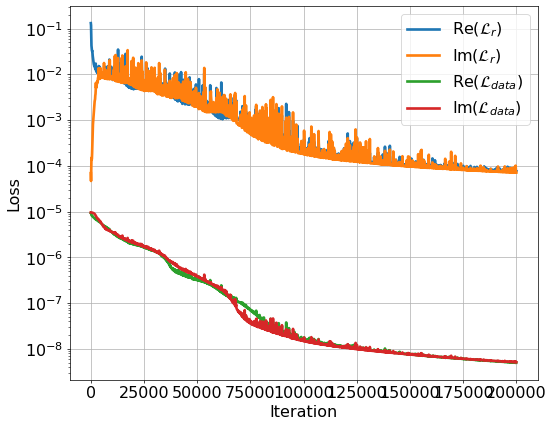

In [14]:
# loss曲线
loss_logger = np.load("./loss_logger_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

k = 100
# ax.plot(loss_logger["iter"][::k], loss_logger["loss"][::k], label=r"$\mathcal{L}$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_res_u"][::k], label=r"Re($\mathcal{L}_{r})$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_res_v"][::k], label=r"Im($\mathcal{L}_{r})$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_data_u"][::k], label=r"Re($\mathcal{L}_{data})$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_data_v"][::k], label=r"Im($\mathcal{L}_{data})$", linewidth=3)
ax.set_yscale('log')
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid()

ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('Loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [15]:
backbone = MLP(mlp_layers)
nn_k = MLP(mlp_layers_k)
pinn = PINNHelmholtz(backbone, nn_k)
pinn = pinn.to(device)
model_state = torch.load(os.path.join(model_path, 'backbone_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_k.load_state_dict(model_state['nn_k_state'])

<All keys matched successfully>

In [16]:
def func_k(X_res):
    k = np.empty(X_res.shape[0])
    k0_ = k0.item()
    for i in range(X_res.shape[0]):
        x1, x2 = X_res[i]
        if (-0.5 < x1) and (x1 < 0) and (-0.25 < x2) and (x2 < 0.25):
            k[i] = k0_ / 1.5
        else:
            k[i] = k0_
    k = k.reshape(-1, 1)
    return k

In [17]:
# relative L2 误差
x_test = x[0, 256:-256][::5]
y_test = y[0, 256:-256][::5]

xx, yy = np.meshgrid(x_test, y_test)

uf_test = uf[256:-256, 256:-256]
uf_test = uf_test[::5, ::5]

uu = uf_test.real
vv = uf_test.imag

X = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)

X = torch.from_numpy(X).float().to(device)
uv_pred = pinn.net_u(X).detach().cpu().numpy()

kk_pred = pinn.net_k(X).detach().cpu().numpy().reshape(xx.shape)
kk = func_k(X.detach().cpu().numpy()).reshape(xx.shape)


uu_pred = uv_pred[:, 0].reshape(xx.shape)
vv_pred = uv_pred[:, 1].reshape(xx.shape)

error_u = np.linalg.norm(uu_pred - uu) / np.linalg.norm(uu)
error_v = np.linalg.norm(vv_pred - vv) / np.linalg.norm(vv)
error_k = np.linalg.norm(kk_pred - kk) / np.linalg.norm(kk)
print('u Relative l2 error: {:.3e}'.format(error_u))
print('v Relative l2 error: {:.3e}'.format(error_v))
print('k Relative l2 error: {:.3e}'.format(error_k))

u Relative l2 error: 2.361e-02
v Relative l2 error: 2.299e-02
k Relative l2 error: 3.470e-02


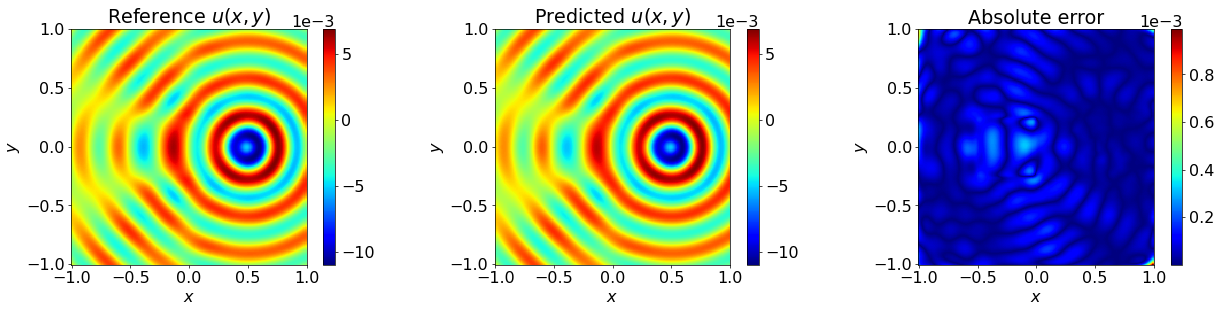

In [18]:
fig = plt.figure(figsize=(20, 5), dpi=64)
[ax, ax2, ax3] = fig.subplots(1, 3)

cax = ax.pcolor(xx, yy, uu, cmap='jet')
cbar = fig.colorbar(cax)
cbar.formatter.set_powerlimits((-3, -3))
cbar.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $u(x,y)$')
ax.set_xticks(np.linspace(-1, 1, 5))
ax.set_yticks(np.linspace(-1, 1, 5))
ax.set_aspect(1./ax.get_data_ratio())

cax2 = ax2.pcolor(xx, yy, uu_pred, cmap='jet')
cbar2 = fig.colorbar(cax2)
cbar2.formatter.set_powerlimits((-3, -3))
cbar2.update_ticks()
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title(r'Predicted $u(x,y)$')
ax2.set_xticks(np.linspace(-1, 1, 5))
ax2.set_yticks(np.linspace(-1, 1, 5))
ax2.set_aspect(1./ax.get_data_ratio())

cax3 = ax3.pcolor(xx, yy, np.abs(uu - uu_pred), cmap='jet')
cbar3 = fig.colorbar(cax3)
cbar3.formatter.set_powerlimits((-3, -3))
cbar3.update_ticks()
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax3.set_title(r'Absolute error')
ax3.set_xticks(np.linspace(-1, 1, 5))
ax3.set_yticks(np.linspace(-1, 1, 5))
ax3.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig('Helmholtz_result_real.png')
plt.show()

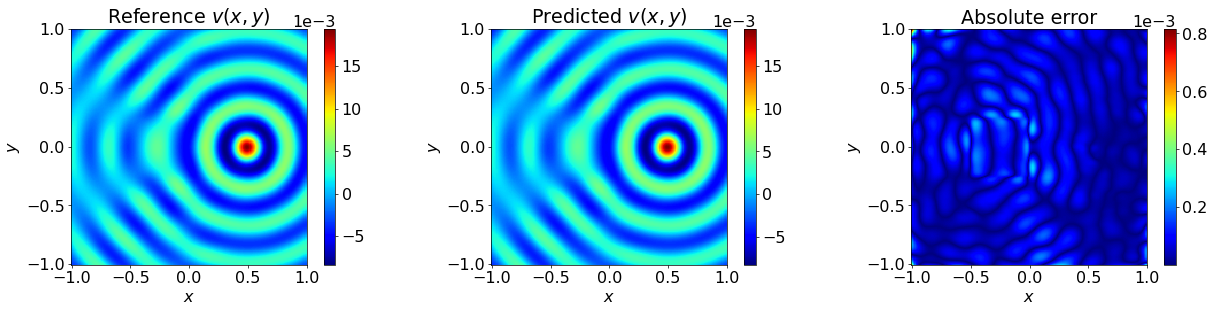

In [19]:
fig = plt.figure(figsize=(20, 5), dpi=64)
[ax, ax2, ax3] = fig.subplots(1, 3)

cax = ax.pcolor(xx, yy, vv, cmap='jet')
cbar = fig.colorbar(cax)
cbar.formatter.set_powerlimits((-3, -3))
cbar.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $v(x,y)$')
ax.set_xticks(np.linspace(-1, 1, 5))
ax.set_yticks(np.linspace(-1, 1, 5))
ax.set_aspect(1./ax.get_data_ratio())

cax2 = ax2.pcolor(xx, yy, vv_pred, cmap='jet')
cbar2 = fig.colorbar(cax2)
cbar2.formatter.set_powerlimits((-3, -3))
cbar2.update_ticks()
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title(r'Predicted $v(x,y)$')
ax2.set_xticks(np.linspace(-1, 1, 5))
ax2.set_yticks(np.linspace(-1, 1, 5))
ax2.set_aspect(1./ax.get_data_ratio())

cax3 = ax3.pcolor(xx, yy, np.abs(vv - vv_pred), cmap='jet')
cbar3 = fig.colorbar(cax3)
cbar3.formatter.set_powerlimits((-3, -3))
cbar3.update_ticks()
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax3.set_title(r'Absolute error')
ax3.set_xticks(np.linspace(-1, 1, 5))
ax3.set_yticks(np.linspace(-1, 1, 5))
ax3.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig('Helmholtz_result_imag.png')
plt.show()

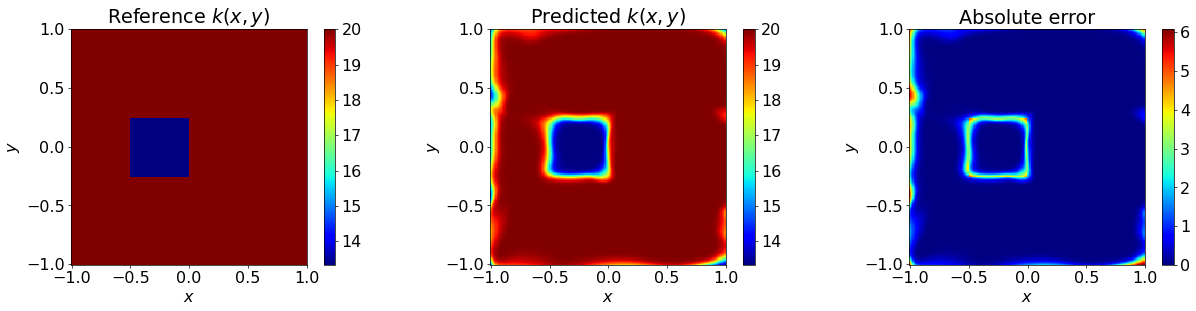

In [20]:
fig = plt.figure(figsize=(20, 5), dpi=64)
[ax, ax2, ax3] = fig.subplots(1, 3)

cax = ax.pcolor(xx, yy, kk, cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $k(x,y)$')
ax.set_xticks(np.linspace(-1, 1, 5))
ax.set_yticks(np.linspace(-1, 1, 5))
ax.set_aspect(1./ax.get_data_ratio())

cax2 = ax2.pcolor(xx, yy, kk_pred, cmap='jet')
cbar2 = fig.colorbar(cax2)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title(r'Predicted $k(x,y)$')
ax2.set_xticks(np.linspace(-1, 1, 5))
ax2.set_yticks(np.linspace(-1, 1, 5))
ax2.set_aspect(1./ax.get_data_ratio())

cax3 = ax3.pcolor(xx, yy, np.abs(kk - kk_pred), cmap='jet')
cbar3 = fig.colorbar(cax3)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax3.set_title(r'Absolute error')
ax3.set_xticks(np.linspace(-1, 1, 5))
ax3.set_yticks(np.linspace(-1, 1, 5))
ax3.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig('Helmholtz_result_k.png')
plt.show()